In [356]:
from src.s3_util_HA import S3Util
s3=S3Util()

from src.ES_wrapper import QueryES
es=QueryES()

from itertools import groupby
import numpy as np

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [357]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

In [358]:
import re
import json
import spacy
import scispacy
# from scispacy.abbreviation import AbbreviationDetector
# https://github.com/allenai/scispacy
# nlp = spacy.load("en_core_web_md")
nlp = spacy.load('en_core_sci_md')
nlp.vocab.add_flag(lambda s: s in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)

from collections import *

from tqdm import tqdm
import pandas as pd

# Read data from S3

In [359]:
gold_s3="projects/MRFT_HA/Gold-Attachments-List.csv"

In [360]:
from io import StringIO
gold_labels=pd.read_csv(StringIO(s3.read_byte_file(gold_s3).decode()), sep=",")

In [361]:
gold_labels

,org_name,attachment_id
0,Foundation,1a544ac7-6982-4253-b8bc-7cc34e07c24e
1,Foundation,84bf943a-76fc-4a17-9e53-01a9116a45d5
2,Foundation,c962c3de-6c66-41eb-878c-6341f45f48a1
3,Foundation,c58b2eac-5703-4405-b88f-69c4b384b78e
4,Neogenomics,d69136c7-cb40-4f78-bbab-4bbff77fc409
...,...,...
69,OncotypeDx,cc7bdd00-f8bd-4d00-ad4e-2aed69e3b933
70,OncotypeDx,5838ca2d-d3a7-44b9-b28b-9a8358437846
71,OncotypeDx,a61a1a7c-2cfd-427f-8c95-cea8be68f5be
72,OncotypeDx,15bb3774-02b8-4dfc-b45e-2bd6a112a8a7


In [362]:
att_to_org_map={}
for _, row in gold_labels.iterrows():
    att_to_org_map[row.attachment_id]=row.org_name

# BoW

In [363]:
gold_es_hits=es.search_list("attachment_id", gold_labels["attachment_id"].to_list())

In [364]:
len(gold_es_hits)

73

In [365]:
def preprocess(cont):
    cont=''.join(c for c, _ in groupby(cont)) # remove duplicated consecutive characters
    return [token.text.lower() for token in nlp(cont) if len(token.text)>2 
                                                        and not token.is_stop and not token.is_digit 
                                                        and not token.is_punct and not token.like_num]

In [366]:
gold_per_org=defaultdict(list)
for hit in gold_es_hits:
    org=att_to_org_map[hit["_source"]["attachment_id"]]
    for page in hit["_source"]["doc_pages"]:
        gold_per_org[org]+=preprocess(page["page_contents"])

In [367]:
print(gold_per_org["Caris"][:20])

['gfi', 'faxmaker', 'nathan', 'nathan', 'page', 'date', '3:54:45', 'caris', 'profile', 'life', 'sciences', 'molecular', 'inteligence', 'tumor', 'rlport', 'page', 'lui', 'chit', 'pase', 'sele']


# Build vectors

In [368]:
from sklearn.feature_extraction.text import CountVectorizer

In [369]:
vectorizer = CountVectorizer()

In [370]:
corpus=[]
for org in gold_per_org:
    print(org)
    corpus.append(" ".join(gold_per_org[org]))

Caris
OncotypeDx
Foundation
Neogenomics
TumorNext
Guardant360


In [371]:
X = vectorizer.fit_transform(corpus)

In [372]:
len(vectorizer.get_feature_names())

9166

In [373]:
X.toarray()

array([[ 5,  0,  0, ...,  0,  0,  0],
       [ 4,  0,  0, ...,  0,  0,  1],
       [ 3,  1,  9, ...,  4,  1,  0],
       [ 4,  0,  3, ...,  0,  0,  0],
       [ 5,  0,  1, ...,  0,  0,  0],
       [10,  0, 11, ...,  0,  0,  0]])

In [374]:
def prune_feature_vector(X_1, X_2):
    non=np.count_nonzero(X_1, axis=0)
    return np.delete(X_2, np.where(non > 1), axis=1)

In [375]:
X_2=prune_feature_vector(X.toarray(), X.toarray())

# Test

In [174]:
patient_id="f5e18edf-5cb9-4eba-b5cc-4807de2a80c6" # Foundation
# patient_id="3c9f0359-311b-4c6e-9442-e0f5e9161a4d"

# patient_id="c91e20df-0833-4ed5-8752-d6fbd24082e3" # Neogenomics

# patient_id="15999170-06b6-4b69-8d64-a1b678caba26" # TumorNext

# patient_id="208ce8e3-3b7c-4584-85ab-db1c6428dca9" # OncotypeDX

# patient_id="96d10472-12d8-41a1-bd61-3ab8d9befcbe" # Caris
# patient_id="2c0fc99a-03c4-4f2f-9f64-46b10e55f600"
# patient_id="8d39044b-4fd4-4c7f-ab3e-dd149caf8d30"

# patient_id="ed192b11-975f-4b75-ae4d-4d520c76390a" # Guardant360

In [175]:
hits=es.search_list("patient_id", [patient_id])
len(hits)

214

In [176]:
similarity=np.zeros((6, 1))
for hit in hits:
    for page in hit["_source"]["doc_pages"]:
        doc=" ".join(preprocess(page["page_contents"]))
        Y=vectorizer.transform([doc]).toarray()
        Y = prune_feature_vector(X.toarray(), Y)
        similarity+=cosine_similarity(X_2, Y)

In [177]:
similarity/similarity.sum(axis=0,keepdims=1)

array([[0.12301654],
       [0.03179487],
       [0.37972266],
       [0.21103854],
       [0.2084608 ],
       [0.04596659]])

In [178]:
list(gold_per_org)[np.argmax(similarity)]

'Foundation'

# Testing

In [179]:
gold_patients_s3="projects/MRFT_HA/Gold_Labels_Top_6_and_Negative.csv"
gold_patients=pd.read_csv(StringIO(s3.read_byte_file(gold_patients_s3).decode()), sep=",")

In [180]:
gold_patients

,PatientID,OrgName
0,f5e18edf-5cb9-4eba-b5cc-4807de2a80c6,FoundationOne
1,fb21bf57-bf9e-42ed-8e0d-2b7b6cc82120,FoundationOne
2,c4cff821-323c-4852-bdff-a6d8e3ba7d4e,FoundationOne
3,ec5ed46a-d1a8-4135-8317-dc2ee255bb65,FoundationOne
4,22cdb219-4d1b-481e-97e7-4f62f3807193,FoundationOne
...,...,...
514,e7133095-977d-454d-bbab-da207142f883,Guardant360
515,99eac447-6e57-4a37-bdcb-3534e0a2af69,Guardant360
516,d7cdf334-071b-4da4-aefb-4268a02c2e47,Guardant360
517,6c6869af-e83c-4bd7-9bbc-fd1da70c6e92,Guardant360


In [182]:
set(gold_patients.OrgName.to_list())

{'Caris',
 'FoundationOne',
 'Guardant360',
 'Negative',
 'Neogenomics',
 'OncotypeDX',
 'TumorNext'}

In [183]:
list(gold_per_org)

['Caris',
 'OncotypeDx',
 'Foundation',
 'Neogenomics',
 'TumorNext',
 'Guardant360']

In [184]:
# FoundationOne == Foundation

In [188]:
hits_s3="projects/MRFT_HA/Gold_Labels_Top_6_and_Negative_ES_hits.json"
gold_es_hits=json.loads(s3.read_byte_file(hits_s3).decode())

In [211]:
patients_hits_s3=defaultdict(list)
for hit in gold_es_hits:
    patients_hits_s3[hit["_source"]["patient_id"]].append(hit)

In [376]:
'''
TODO: 

1- check if only getting the highest among all docs would be better
2- check more than unigrams
3- tfidf instead of countvectorizer
4- threshold for the negative class
'''
#features_bank=defaultdict(lambda: defaultdict(lambda: defaultdict()))

with open("features_bank.pkl", "rb") as inf:
    features_bank=dill.load(inf)
    
def test_patient(patient_id):
#     hits=es.search_list("patient_id", [patient_id])
    
    hits=patients_hits_s3[patient_id]
    
    similarity=np.zeros((6, 1))
    for hit in hits:
#         print(hit)
        for page in hit["_source"]["doc_pages"]:
#             doc=" ".join(preprocess(page["page_contents"]))
            doc=features_bank[patient_id][hit["_source"]["attachment_id"]][page['page_num']]
            
#             print(features_bank[patient_id][hit["_source"]["attachment_id"]][page["page_num"]])
#             break
            dev
            Y=vectorizer.transform([doc]).toarray()
            Y = prune_feature_vector(X.toarray(), Y)
            similarity+=cosine_similarity(X_2, Y)
#         break
    return list(gold_per_org)[np.argmax(similarity)]

def test_patient_2(patient_id):
#     hits=es.search_list("patient_id", [patient_id])
    
    hits=patients_hits_s3[patient_id]
    
    similarity=np.zeros((6, 1))
    similarities=[]
    for hit in hits:
        for page in hit["_source"]["doc_pages"]:
            doc=features_bank[patient_id][hit["_source"]["attachment_id"]][page['page_num']]
            Y=vectorizer.transform([doc]).toarray()
            Y = prune_feature_vector(X.toarray(), Y)
            sim=cosine_similarity(X_2, Y)
            
            similarities.append(sim)
            
            similarity+=sim
    return list(gold_per_org)[np.argmax(similarity)], similarities, similarity

def test_patient_3(patient_id, threshold=0.2):
#     hits=es.search_list("patient_id", [patient_id])
    
    hits=patients_hits_s3[patient_id]
    
    similarity=np.zeros((6, 1))
    similarities=[]
    for hit in hits:
        for page in hit["_source"]["doc_pages"]:
            doc=features_bank[patient_id][hit["_source"]["attachment_id"]][page['page_num']]
            Y=vectorizer.transform([doc]).toarray()
            Y = prune_feature_vector(X.toarray(), Y)
            sim=cosine_similarity(X_2, Y)
            
            similarities.append(cosine_similarity(X_2, Y))
            
            sim[sim>=threshold]=1
            sim[sim<threshold]=0
            
            similarity+=sim
    return list(gold_per_org)[np.argmax(similarity)], similarities, similarity

In [256]:
# import dill
# with open("features_bank.pkl", "wb") as outf:
#     dill.dump(features_bank, outf)

In [229]:
# def test_patient(patient_id):
# #     hits=es.search_list("patient_id", [patient_id])
    
#     hits=patients_hits_s3[patient_id]
    
#     similarity=np.zeros((6, 1))
#     doc=[]
#     for hit in hits:
#         for page in hit["_source"]["doc_pages"]:
#             doc.append(page["page_contents"])
    
#     doc=" ".join(preprocess("\n\n".join(doc)))
    
#     Y=vectorizer.transform([doc]).toarray()
#     Y = prune_feature_vector(X.toarray(), Y)
#     similarity=cosine_similarity(X_2, Y)
    
#     return list(gold_per_org)[np.argmax(similarity)], similarity

In [338]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [377]:
# gold_patients_neg=gold_patients[gold_patients.OrgName=="Negative"]
# gold_patients_f1=gold_patients[gold_patients.OrgName=="Neogenomics"]

for threshold in [0.2]:#frange(0.05, 0.5, 0.05):
    y_gold=gold_patients.OrgName.to_list()
    y_pred_x=[]
    for _, row in tqdm(gold_patients.iterrows(), total=gold_patients.shape[0], position=0, leave=True):
        res, similarities, similarity=test_patient_3(row.PatientID, threshold)

    #     similarity=np.zeros((6, 1))
    #     for sim in similarities:
    #         sim[sim>=0.1]=1
    #         sim[sim<0.1]=0
    #         similarity+=b
    #     res=list(gold_per_org)[np.argmax(similarity)]

        if not np.any(similarity):
            res="Negative"

        if res == "Foundation":
            res="FoundationOne"
        elif res=="OncotypeDx":
            res="OncotypeDX"
        y_pred_x.append(res)
    
    print("#"*50)
    print(threshold)
    print(classification_report(y_gold,y_pred_x))

100%|██████████| 519/519 [03:16<00:00,  2.64it/s]

##################################################
0.2
               precision    recall  f1-score   support

        Caris       0.88      0.98      0.93        84
FoundationOne       0.83      0.86      0.84        79
  Guardant360       0.98      0.72      0.83        58
     Negative       0.79      0.77      0.78        39
  Neogenomics       0.99      0.89      0.94        76
   OncotypeDX       0.62      0.95      0.75        93
    TumorNext       0.98      0.57      0.72        90

     accuracy                           0.83       519
    macro avg       0.87      0.82      0.83       519
 weighted avg       0.86      0.83      0.83       519



In [225]:
y_pred_2=["OncotypeDX" if x=="OncotypeDx" else x for x in y_pred]

In [228]:
from sklearn.metrics import classification_report
target_names=['Caris', 'FoundationOne', 'Guardant360', 'Neogenomics', 'OncotypeDX', 'TumorNext']
print(classification_report(y_gold,y_pred_2, labels=target_names))

               precision    recall  f1-score   support

        Caris       0.80      0.86      0.83        84
FoundationOne       0.64      0.78      0.70        79
  Guardant360       0.88      0.38      0.53        58
  Neogenomics       0.83      0.82      0.82        76
   OncotypeDX       0.75      0.88      0.81        93
    TumorNext       0.58      0.79      0.67        90

    micro avg       0.71      0.77      0.74       480
    macro avg       0.75      0.75      0.73       480
 weighted avg       0.74      0.77      0.74       480



In [294]:
print(classification_report(y_gold,y_pred_x))

               precision    recall  f1-score   support

        Caris       0.88      0.98      0.93        84
FoundationOne       0.83      0.85      0.84        79
  Guardant360       0.98      0.72      0.83        58
     Negative       0.79      0.77      0.78        39
  Neogenomics       0.99      0.89      0.94        76
   OncotypeDX       0.62      0.95      0.75        93
    TumorNext       0.98      0.59      0.74        90

     accuracy                           0.83       519
    macro avg       0.87      0.82      0.83       519
 weighted avg       0.86      0.83      0.83       519



In [378]:
# This is after removing BRACAnalysis
print(classification_report(y_gold,y_pred_x))

               precision    recall  f1-score   support

        Caris       0.88      0.98      0.93        84
FoundationOne       0.83      0.86      0.84        79
  Guardant360       0.98      0.72      0.83        58
     Negative       0.79      0.77      0.78        39
  Neogenomics       0.99      0.89      0.94        76
   OncotypeDX       0.62      0.95      0.75        93
    TumorNext       0.98      0.57      0.72        90

     accuracy                           0.83       519
    macro avg       0.87      0.82      0.83       519
 weighted avg       0.86      0.83      0.83       519



----

In [303]:
negative_sims

[array([[0.00637065],
        [0.00038386],
        [0.00781743],
        [0.02578837],
        [0.02471521],
        [0.00128023]]),
 array([[0.00555084],
        [0.        ],
        [0.00527075],
        [0.01192273],
        [0.02999475],
        [0.        ]]),
 array([[0.00790058],
        [0.1168107 ],
        [0.01247196],
        [0.        ],
        [0.01245182],
        [0.00257998]]),
 array([[0.04147807],
        [0.45426382],
        [0.01148733],
        [0.        ],
        [0.00968475],
        [0.0040133 ]]),
 array([[0.00168912],
        [0.        ],
        [0.00645565],
        [0.05396771],
        [0.00798647],
        [0.00441272]]),
 array([[0.        ],
        [0.        ],
        [0.00402057],
        [0.02598499],
        [0.01089534],
        [0.        ]]),
 array([[0.00272317],
        [0.10736597],
        [0.01357525],
        [0.        ],
        [0.01144503],
        [0.00474275]]),
 array([[0.00139823],
        [0.        ],
        [0.0055762

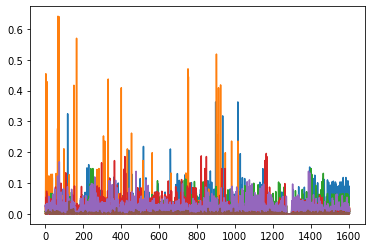

In [321]:
# Negative
from matplotlib import pyplot as plt
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

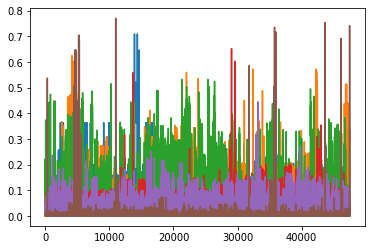

In [324]:
# FoundationOne
from matplotlib import pyplot as plt
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

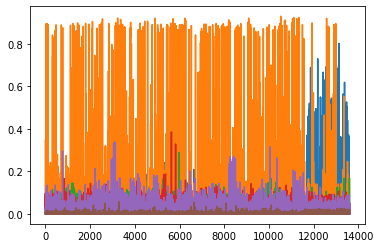

In [326]:
# OncotypeDX
from matplotlib import pyplot as plt
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

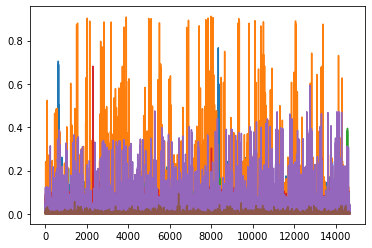

In [328]:
#TumorNext
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

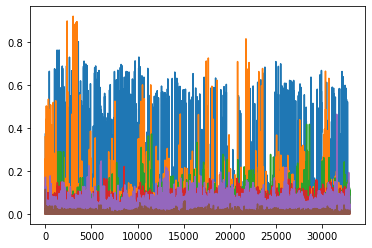

In [330]:
# Caris
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

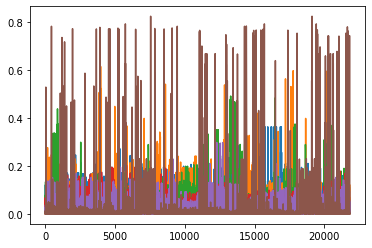

In [333]:
# Guardant360
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

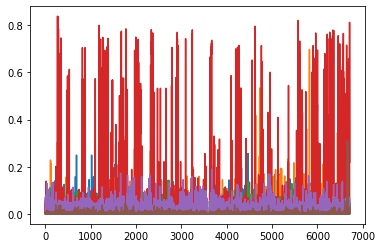

In [335]:
# Neogenomics
plt.plot(*np.stack( negative_sims, axis=1).T)
plt.show()

# Thresholds

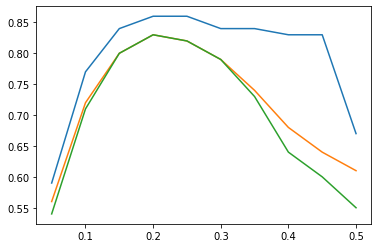

In [355]:
r=[ [0.05, 0.59, 0.56, 0.54],
    [0.1, 0.77, 0.72, 0.71],
    [0.15, 0.84, 0.80, 0.80],
    [0.2, 0.86, 0.83, 0.83],
    [0.25, 0.86, 0.82, 0.82],
    [0.3, 0.84, 0.79, 0.79],
    [0.35, 0.84, 0.74, 0.73],
    [0.4, 0.83, 0.68, 0.64],
    [0.45, 0.83, 0.64, 0.60],
    [0.5, 0.67, 0.61, 0.55]
  ]

plt.plot(np.array(r)[:,0],np.delete(np.array(r), 0, axis=1))
plt.show()

In [ ]:
100%|██████████| 519/519 [04:23<00:00,  1.97it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.05
               precision    recall  f1-score   support

        Caris       0.48      0.55      0.51        84
FoundationOne       0.50      0.66      0.57        79
  Guardant360       0.93      0.24      0.38        58
     Negative       0.40      0.05      0.09        39
  Neogenomics       0.58      0.61      0.59        76
   OncotypeDX       0.71      0.69      0.70        93
    TumorNext       0.52      0.76      0.62        90

     accuracy                           0.56       519
    macro avg       0.59      0.51      0.49       519
 weighted avg       0.59      0.56      0.54       519

100%|██████████| 519/519 [03:25<00:00,  2.53it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.1
               precision    recall  f1-score   support

        Caris       0.65      0.93      0.76        84
FoundationOne       0.73      0.77      0.75        79
  Guardant360       0.92      0.41      0.57        58
     Negative       0.83      0.38      0.53        39
  Neogenomics       0.95      0.74      0.83        76
   OncotypeDX       0.57      0.91      0.70        93
    TumorNext       0.84      0.59      0.69        90

     accuracy                           0.72       519
    macro avg       0.79      0.68      0.69       519
 weighted avg       0.77      0.72      0.71       519

100%|██████████| 519/519 [03:21<00:00,  2.58it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.15000000000000002
               precision    recall  f1-score   support

        Caris       0.75      0.95      0.84        84
FoundationOne       0.82      0.84      0.83        79
  Guardant360       0.97      0.59      0.73        58
     Negative       0.81      0.67      0.73        39
  Neogenomics       0.99      0.88      0.93        76
   OncotypeDX       0.62      0.95      0.75        93
    TumorNext       0.98      0.60      0.74        90

     accuracy                           0.80       519
    macro avg       0.85      0.78      0.79       519
 weighted avg       0.84      0.80      0.80       519

100%|██████████| 519/519 [03:16<00:00,  2.64it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.2
               precision    recall  f1-score   support

        Caris       0.88      0.98      0.93        84
FoundationOne       0.83      0.85      0.84        79
  Guardant360       0.98      0.72      0.83        58
     Negative       0.79      0.77      0.78        39
  Neogenomics       0.99      0.89      0.94        76
   OncotypeDX       0.62      0.95      0.75        93
    TumorNext       0.98      0.59      0.74        90

     accuracy                           0.83       519
    macro avg       0.87      0.82      0.83       519
 weighted avg       0.86      0.83      0.83       519

100%|██████████| 519/519 [03:16<00:00,  2.64it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.25
               precision    recall  f1-score   support

        Caris       0.89      0.98      0.93        84
FoundationOne       0.85      0.80      0.82        79
  Guardant360       0.94      0.78      0.85        58
     Negative       0.71      0.82      0.76        39
  Neogenomics       0.99      0.91      0.95        76
   OncotypeDX       0.63      0.95      0.76        93
    TumorNext       0.98      0.54      0.70        90

     accuracy                           0.82       519
    macro avg       0.86      0.82      0.82       519
 weighted avg       0.86      0.82      0.82       519

100%|██████████| 519/519 [03:17<00:00,  2.63it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.3
               precision    recall  f1-score   support

        Caris       0.87      0.99      0.93        84
FoundationOne       0.85      0.71      0.77        79
  Guardant360       0.92      0.81      0.86        58
     Negative       0.55      0.82      0.66        39
  Neogenomics       0.98      0.86      0.92        76
   OncotypeDX       0.62      0.95      0.75        93
    TumorNext       1.00      0.46      0.63        90

     accuracy                           0.79       519
    macro avg       0.83      0.80      0.79       519
 weighted avg       0.84      0.79      0.79       519

100%|██████████| 519/519 [03:19<00:00,  2.60it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.35
               precision    recall  f1-score   support

        Caris       0.90      0.99      0.94        84
FoundationOne       0.90      0.48      0.63        79
  Guardant360       0.88      0.90      0.89        58
     Negative       0.38      0.82      0.52        39
  Neogenomics       0.98      0.86      0.92        76
   OncotypeDX       0.59      0.95      0.73        93
    TumorNext       1.00      0.31      0.47        90

     accuracy                           0.74       519
    macro avg       0.81      0.76      0.73       519
 weighted avg       0.84      0.74      0.73       519

100%|██████████| 519/519 [03:27<00:00,  2.50it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.39999999999999997
               precision    recall  f1-score   support

        Caris       0.94      0.96      0.95        84
FoundationOne       0.96      0.28      0.43        79
  Guardant360       0.89      0.93      0.91        58
     Negative       0.27      0.82      0.40        39
  Neogenomics       0.96      0.86      0.90        76
   OncotypeDX       0.58      0.95      0.72        93
    TumorNext       1.00      0.10      0.18        90

     accuracy                           0.68       519
    macro avg       0.80      0.70      0.64       519
 weighted avg       0.83      0.68      0.64       519

100%|██████████| 519/519 [03:24<00:00,  2.54it/s]
  0%|          | 0/519 [00:00<?, ?it/s]
##################################################
0.44999999999999996
               precision    recall  f1-score   support

        Caris       0.94      0.96      0.95        84
FoundationOne       0.93      0.16      0.28        79
  Guardant360       0.87      0.93      0.90        58
     Negative       0.23      0.87      0.36        39
  Neogenomics       0.95      0.82      0.88        76
   OncotypeDX       0.62      0.92      0.74        93
    TumorNext       1.00      0.04      0.09        90

     accuracy                           0.64       519
    macro avg       0.79      0.67      0.60       519
 weighted avg       0.83      0.64      0.60       519

100%|██████████| 519/519 [03:23<00:00,  2.55it/s]
##################################################
0.49999999999999994
               precision    recall  f1-score   support

        Caris       0.94      0.92      0.93        84
FoundationOne       1.00      0.05      0.10        79
  Guardant360       0.87      0.90      0.88        58
     Negative       0.20      0.92      0.33        39
  Neogenomics       0.95      0.79      0.86        76
   OncotypeDX       0.66      0.92      0.77        93
    TumorNext       0.00      0.00      0.00        90

     accuracy                           0.61       519
    macro avg       0.66      0.64      0.55       519
 weighted avg       0.67      0.61      0.55       519